In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Mouse_bite/01_mouse_bite_11.xml
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Mouse_bite/01_mouse_bite_17.xml
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Mouse_bite/08_mouse_bite_08.xml
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Mouse_bite/08_mouse_bite_02.xml
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Mouse_bite/07_mouse_bite_03.xml
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Mouse_bite/01_mouse_bite_09.xml
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Mouse_bite/05_mouse_bite_06.xml
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Mouse_bite/01_mouse_bite_18.xml
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Mouse_bite/05_mouse_bite_02.xml
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Mouse_bite/04_mouse_bite_20.xml
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Mouse_bite/06_mouse_bite_07.xml
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Mouse_bite/01_mouse_bite_20.xml
/kaggle/input/pc

In [2]:
# Core DETR requirements + COCO tools
!pip install cython matplotlib pycocotools panopticapi submitit onnx onnxruntime

# (optional) other utilities you need
!pip install tqdm

ERROR: Could not find a version that satisfies the requirement panopticapi (from versions: none)
ERROR: No matching distribution found for panopticapi


In [3]:
# install the remaining DETR dependencies
!pip install submitit onnx onnxruntime

# install COCO Panoptic API from the official repo
!pip install git+https://github.com/cocodataset/panopticapi.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 100.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.5 MB/s eta 0:00:00
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-rl0fyovp
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-rl0fyovp
  Resolved https://github.com/cocodataset/panopticapi.git to commit 7bb4655548f98f3fedc07bf37e9040a992b054b0
  Preparing metadata (setup.py) ... done
  Created wheel for panopticapi: filename=panopticapi-0.1-py3-none-any.whl size=8258 sha256=f6ef1acf0f9b018d9427fbce703d0b1ba5e916989ac8f52954077e94fdb59737
  Stored in directory: /tmp/pip-ephem-wheel-cache-d45tb8ye/wheels/1e/dc/23/d70628297e507c01e9be79a815856549c351a79f86a1af064d
Successfully built panopt

In [4]:
!find /kaggle/input/pcb-dataset/PCB_Dataset -maxdepth 2 | head -20

/kaggle/input/pcb-dataset/PCB_Dataset
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Mouse_bite
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Spur
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Open_circuit
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Short
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Missing_hole
/kaggle/input/pcb-dataset/PCB_Dataset/Annotations/Spurious_copper
/kaggle/input/pcb-dataset/PCB_Dataset/images
/kaggle/input/pcb-dataset/PCB_Dataset/images/Mouse_bite
/kaggle/input/pcb-dataset/PCB_Dataset/images/Spur
/kaggle/input/pcb-dataset/PCB_Dataset/images/Open_circuit
/kaggle/input/pcb-dataset/PCB_Dataset/images/Short
/kaggle/input/pcb-dataset/PCB_Dataset/images/Missing_hole
/kaggle/input/pcb-dataset/PCB_Dataset/images/Spurious_copper


In [5]:
# Copy the mounted dataset into working directory
!cp -r /kaggle/input/pcb-dataset/PCB_Dataset /kaggle/working/PCB_DATASET

# Verify contents
!find /kaggle/working/PCB_DATASET -maxdepth 2 | head -20

/kaggle/working/PCB_DATASET
/kaggle/working/PCB_DATASET/images
/kaggle/working/PCB_DATASET/images/Spurious_copper
/kaggle/working/PCB_DATASET/images/Short
/kaggle/working/PCB_DATASET/images/Mouse_bite
/kaggle/working/PCB_DATASET/images/Open_circuit
/kaggle/working/PCB_DATASET/images/Missing_hole
/kaggle/working/PCB_DATASET/images/Spur
/kaggle/working/PCB_DATASET/Annotations
/kaggle/working/PCB_DATASET/Annotations/Spurious_copper
/kaggle/working/PCB_DATASET/Annotations/Short
/kaggle/working/PCB_DATASET/Annotations/Mouse_bite
/kaggle/working/PCB_DATASET/Annotations/Open_circuit
/kaggle/working/PCB_DATASET/Annotations/Missing_hole
/kaggle/working/PCB_DATASET/Annotations/Spur


In [12]:
import os, json, xml.etree.ElementTree as ET
from PIL import Image
from tqdm.notebook import tqdm

# 6 defect classes
PCB_CLASSES = ["spurious_copper","open_circuit","short","missing_hole","mouse_bite","spur"]
class_to_id = {c:i+1 for i,c in enumerate(PCB_CLASSES)}

images_dir      = "/kaggle/working/PCB_DATASET/images"
annotations_dir = "/kaggle/working/PCB_DATASET/Annotations"
output_json     = "/kaggle/working/instances_pcb.json"

images, annotations = [], []
img_id = ann_id = 0

for cls in os.listdir(images_dir):
    img_folder = os.path.join(images_dir, cls)
    ann_folder = os.path.join(annotations_dir, cls)
    for fname in tqdm(os.listdir(img_folder), desc=cls):
        if not fname.lower().endswith((".jpg",".png")): 
            continue
        xml_path = os.path.join(ann_folder, fname.rsplit(".",1)[0]+".xml")
        if not os.path.exists(xml_path): 
            continue

        # record image info
        w, h = Image.open(os.path.join(img_folder, fname)).size
        images.append({"id": img_id,
                       "file_name": f"{cls}/{fname}",
                       "width": w, "height": h})

        tree = ET.parse(xml_path)
        for obj in tree.findall("object"):
            nm = obj.find("name").text.strip().lower()
            if nm not in class_to_id: 
                continue
            box = obj.find("bndbox")
            xmin = float(box.find("xmin").text)
            ymin = float(box.find("ymin").text)
            xmax = float(box.find("xmax").text)
            ymax = float(box.find("ymax").text)
            w0, h0 = xmax - xmin, ymax - ymin

            annotations.append({
                "id":         ann_id,
                "image_id":   img_id,
                "category_id":class_to_id[nm],
                "bbox":       [xmin, ymin, w0, h0],
                "area":       w0*h0,
                "iscrowd":    0
            })
            ann_id += 1

        img_id += 1

coco = {
    "images": images,
    "annotations": annotations,
    "categories": [{"id":i+1, "name":n} for i,n in enumerate(PCB_CLASSES)]
}

with open(output_json, "w") as f:
    json.dump(coco, f, indent=4)
print("✅ COCO JSON saved to", output_json)

Short:   0%|          | 0/116 [00:00<?, ?it/s]

Mouse_bite:   0%|          | 0/115 [00:00<?, ?it/s]

Spurious_copper:   0%|          | 0/116 [00:00<?, ?it/s]

Missing_hole:   0%|          | 0/115 [00:00<?, ?it/s]

Spur:   0%|          | 0/115 [00:00<?, ?it/s]

Open_circuit:   0%|          | 0/116 [00:00<?, ?it/s]

✅ COCO JSON saved to /kaggle/working/instances_pcb.json


In [29]:
# Cell 2: COCO mAP@0.5
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

VAL_JSON = "/kaggle/working/PCB_COCO/annotations/instances_val2017.json"
PRED_JSON = "/kaggle/working/outputs_pcb_detr/detr_predictions.json"

cocoGt = COCO(VAL_JSON)
# make sure JSON is non‐empty
import json
preds = json.load(open(PRED_JSON))
if len(preds)==0:
    print("⚠️ No predictions found—go back to Cell 1 and lower SCORE_THR")
else:
    cocoDt   = cocoGt.loadRes(PRED_JSON)
    cocoEval = COCOeval(cocoGt, cocoDt, iouType="bbox")
    cocoEval.params.iouThrs = np.array([0.5])
    cocoEval.evaluate()
    cocoEval.accumulate()
    print("\n── COCO mAP @ IoU=0.5 ─────────────────────────")
    cocoEval.summarize()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.47s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.59s).
Accumulating evaluation results...
DONE (t=0.13s).

── COCO mAP @ IoU=0.5 ─────────────────────────
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets= 10 ] = 0.000
 Average Recall

In [30]:
# Cell 3: Precision / Recall / F1 / Accuracy / Mean IoU
import torch
import numpy as np
from pycocotools.coco import COCO
from torchvision.ops.boxes import box_iou
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import json

VAL_JSON = "/kaggle/working/PCB_COCO/annotations/instances_val2017.json"
PRED_JSON = "/kaggle/working/outputs_pcb_detr/detr_predictions.json"

cocoGt = COCO(VAL_JSON)
img_ids = cocoGt.getImgIds()
preds   = json.load(open(PRED_JSON))

all_gts, all_preds, ious = [], [], []

for img_id in tqdm(img_ids, desc="Metrics"):
    # GT
    annIds = cocoGt.getAnnIds(imgIds=img_id, iscrowd=False)
    GTs    = cocoGt.loadAnns(annIds)
    if not GTs: continue

    gt_boxes  = torch.tensor([g["bbox"] for g in GTs], dtype=torch.float32)
    gt_labels = torch.tensor([g["category_id"] for g in GTs], dtype=torch.int64)

    # PRED for this image
    this_p = [p for p in preds if p["image_id"]==img_id]
    if not this_p: continue

    pb = torch.tensor([[*p["bbox"]] for p in this_p], dtype=torch.float32)
    pl = torch.tensor([p["category_id"] for p in this_p], dtype=torch.int64)

    M = box_iou(gt_boxes, pb)  # [ngt x npred]
    for i in range(len(gt_boxes)):
        hits = (M[i]>=0.5).nonzero(as_tuple=True)[0]
        if len(hits)>0:
            j = hits[0]
            all_gts.append(int(gt_labels[i].item()))
            all_preds.append(int(pl[j].item()))
            ious.append(float(M[i,j].item()))

    fn = (M.max(1)[0]<0.5).sum().item()
    fp = (M.max(0)[0]<0.5).sum().item()
    all_gts += [0]*fp;    all_preds += [1]*fp
    all_gts += [1]*fn;    all_preds += [0]*fn# Cell 3: Precision / Recall / F1 / Accuracy / Mean IoU
import torch
import numpy as np
from pycocotools.coco import COCO
from torchvision.ops.boxes import box_iou
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import json

VAL_JSON = "/kaggle/working/PCB_COCO/annotations/instances_val2017.json"
PRED_JSON = "/kaggle/working/outputs_pcb_detr/detr_predictions.json"

cocoGt = COCO(VAL_JSON)
img_ids = cocoGt.getImgIds()
preds   = json.load(open(PRED_JSON))

all_gts, all_preds, ious = [], [], []

for img_id in tqdm(img_ids, desc="Metrics"):
    # GT
    annIds = cocoGt.getAnnIds(imgIds=img_id, iscrowd=False)
    GTs    = cocoGt.loadAnns(annIds)
    if not GTs: continue

    gt_boxes  = torch.tensor([g["bbox"] for g in GTs], dtype=torch.float32)
    gt_labels = torch.tensor([g["category_id"] for g in GTs], dtype=torch.int64)

    # PRED for this image
    this_p = [p for p in preds if p["image_id"]==img_id]
    if not this_p: continue

    pb = torch.tensor([[*p["bbox"]] for p in this_p], dtype=torch.float32)
    pl = torch.tensor([p["category_id"] for p in this_p], dtype=torch.int64)

    M = box_iou(gt_boxes, pb)  # [ngt x npred]
    for i in range(len(gt_boxes)):
        hits = (M[i]>=0.5).nonzero(as_tuple=True)[0]
        if len(hits)>0:
            j = hits[0]
            all_gts.append(int(gt_labels[i].item()))
            all_preds.append(int(pl[j].item()))
            ious.append(float(M[i,j].item()))

    fn = (M.max(1)[0]<0.5).sum().item()
    fp = (M.max(0)[0]<0.5).sum().item()
    all_gts += [0]*fp;    all_preds += [1]*fp
    all_gts += [1]*fn;    all_preds += [0]*fn

prec, rec, f1, _ = precision_recall_fscore_support(all_gts, all_preds, average="weighted", zero_division=0)
acc  = accuracy_score(all_gts, all_preds)
miou = np.mean(ious) if ious else 0.0

print(f"\nPrecision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Mean IoU:  {miou:.4f}")


prec, rec, f1, _ = precision_recall_fscore_support(all_gts, all_preds, average="weighted", zero_division=0)
acc  = accuracy_score(all_gts, all_preds)
miou = np.mean(ious) if ious else 0.0

print(f"\nPrecision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Mean IoU:  {miou:.4f}")


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Metrics:   0%|          | 0/693 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Metrics:   0%|          | 0/693 [00:00<?, ?it/s]


Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000
Accuracy:  0.0000
Mean IoU:  0.0000

Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000
Accuracy:  0.0000
Mean IoU:  0.0000


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


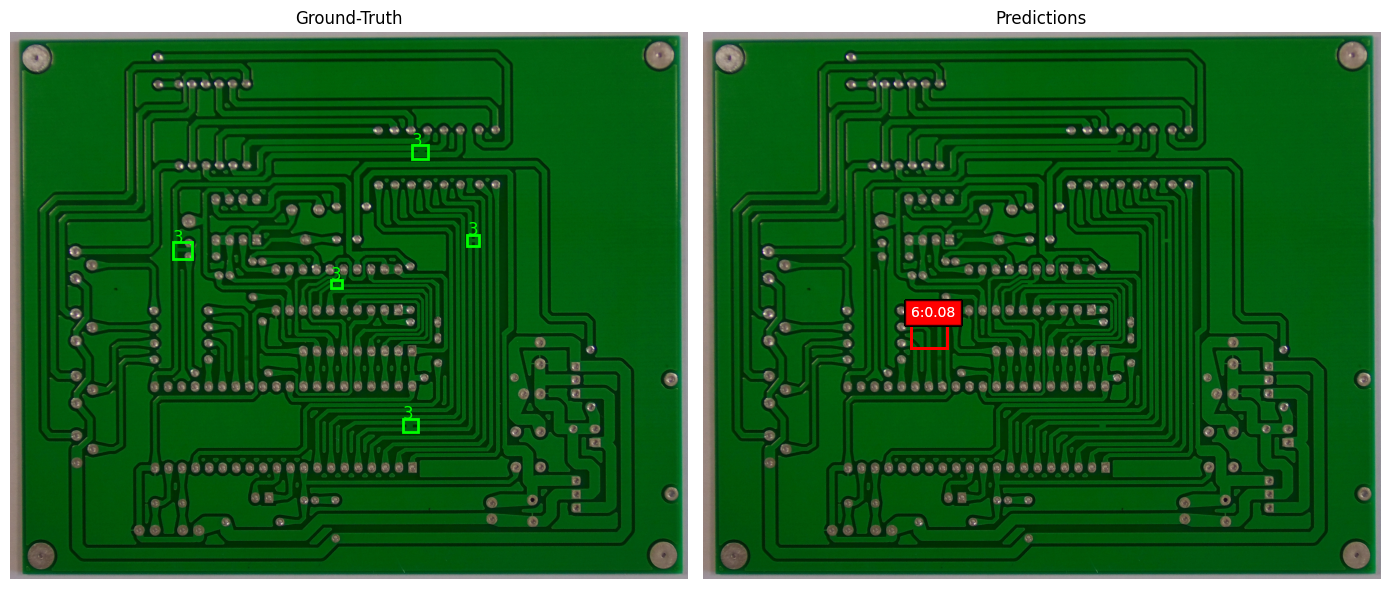

In [31]:
# Cell 4: visualize one example
import json
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

VAL_JSON  = "/kaggle/working/PCB_COCO/annotations/instances_val2017.json"
IMG_DIR   = "/kaggle/working/PCB_COCO/val2017"
PRED_JSON = "/kaggle/working/outputs_pcb_detr/detr_predictions.json"

cocoGt = COCO(VAL_JSON)
img_ids = cocoGt.getImgIds()
preds   = json.load(open(PRED_JSON))

# pick one
img_id = img_ids[0]
info   = cocoGt.loadImgs(img_id)[0]
img    = Image.open(f"{IMG_DIR}/{info['file_name']}").convert("RGB")

fig, axes = plt.subplots(1,2, figsize=(14,6))
for ax, mode in zip(axes, ["Ground-Truth","Predictions"]):
    ax.imshow(img); ax.axis("off"); ax.set_title(mode)
    if mode=="Ground-Truth":
        for g in cocoGt.loadAnns(cocoGt.getAnnIds(imgIds=img_id, iscrowd=False)):
            x,y,w0,h0 = g["bbox"]
            rect = patches.Rectangle((x,y),w0,h0, edgecolor="lime", facecolor="none", lw=2)
            ax.add_patch(rect)
            ax.text(x,y,str(g["category_id"]), color="lime", fontsize=12)
    else:
        for p in [p for p in preds if p["image_id"]==img_id]:
            x,y,w0,h0 = p["bbox"]
            s = p["score"]
            rect = patches.Rectangle((x,y),w0,h0, edgecolor="red", facecolor="none", lw=2)
            ax.add_patch(rect)
            ax.text(x,y,f"{p['category_id']}:{s:.2f}", color="white",
                    bbox=dict(facecolor="red",alpha=0.5))
plt.tight_layout()
plt.show()


In [2]:
import os, json, shutil
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# ───────────────────────────────────────────────────────────────────────────────
RAW_ROOT  = "/kaggle/input/pcb-dataset/PCB_Dataset"
COCO_ROOT = "/kaggle/working/PCB_COCO"

# 1) Create target folders
for d in ["train2017","val2017","annotations"]:
    os.makedirs(os.path.join(COCO_ROOT, d), exist_ok=True)

# 2) Split images & XMLs
IMAGE_IN = os.path.join(RAW_ROOT, "images")
ANN_IN   = os.path.join(RAW_ROOT, "Annotations")

for cls in os.listdir(IMAGE_IN):
    imgs = [f for f in os.listdir(os.path.join(IMAGE_IN,cls))
            if f.lower().endswith((".jpg",".png"))]
    train, val = train_test_split(imgs, test_size=0.2, random_state=42)
    for split, files in [("train2017", train), ("val2017", val)]:
        for f in files:
            shutil.copy(os.path.join(IMAGE_IN,cls,f),
                        os.path.join(COCO_ROOT, split, f))
            xml = f.rsplit(".",1)[0] + ".xml"
            shutil.copy(os.path.join(ANN_IN,cls,xml),
                        os.path.join(COCO_ROOT, split, xml))

# 3) Build COCO JSON
CATEGORIES = [
    {"id":1, "name":"spurious_copper"},
    {"id":2, "name":"open_circuit"},
    {"id":3, "name":"short"},
    {"id":4, "name":"missing_hole"},
    {"id":5, "name":"mouse_bite"},
    {"id":6, "name":"spur"},
]

def make_coco_json(split):
    img_dir = os.path.join(COCO_ROOT, split)
    images, anns = [], []
    img_id = ann_id = 1
    for img in tqdm(os.listdir(img_dir), desc=f"→ {split}"):
        if not img.lower().endswith((".jpg",".png")): continue
        tree = ET.parse(os.path.join(img_dir, img.rsplit(".",1)[0]+".xml"))
        w = int(tree.find("size/width").text)
        h = int(tree.find("size/height").text)
        images.append({"file_name":img,"height":h,"width":w,"id":img_id})
        for obj in tree.findall("object"):
            cls = obj.find("name").text.lower()
            x0 = float(obj.find("bndbox/xmin").text)
            y0 = float(obj.find("bndbox/ymin").text)
            x1 = float(obj.find("bndbox/xmax").text)
            y1 = float(obj.find("bndbox/ymax").text)
            cid = next(c["id"] for c in CATEGORIES if c["name"]==cls)
            anns.append({
                "id":ann_id,
                "image_id":img_id,
                "category_id":cid,
                "bbox":[x0,y0,x1-x0,y1-y0],
                "area":(x1-x0)*(y1-y0),
                "iscrowd":0
            })
            ann_id += 1
        img_id += 1
    out = {"images":images,"annotations":anns,"categories":CATEGORIES}
    p = os.path.join(COCO_ROOT,"annotations",f"instances_{split}.json")
    with open(p,"w") as f: json.dump(out,f)
    print(f"→ Wrote {p}: {len(images)} imgs, {len(anns)} anns")

make_coco_json("train2017")
make_coco_json("val2017")


→ train2017:   0%|          | 0/1104 [00:00<?, ?it/s]

→ Wrote /kaggle/working/PCB_COCO/annotations/instances_train2017.json: 552 imgs, 2346 anns


→ val2017:   0%|          | 0/282 [00:00<?, ?it/s]

→ Wrote /kaggle/working/PCB_COCO/annotations/instances_val2017.json: 141 imgs, 607 anns


In [11]:
%%bash
cd /kaggle/working/detr

# Run training with full output visible (no grep)
python -u main.py \
  --dataset_file coco \
  --coco_path /kaggle/working/PCB_COCO \
  --batch_size 2 \
  --epochs 5 \
  --lr 2e-4 \
  --lr_backbone 2e-5 \
  --lr_drop 30 \
  --weight_decay 1e-4 \
  --output_dir /kaggle/working/outputs_pcb_detr \
  --device cuda \
  --num_classes 6


usage: DETR training and evaluation script [-h] [--lr LR] [--lr_backbone LR_BACKBONE]
                                           [--batch_size BATCH_SIZE] [--weight_decay WEIGHT_DECAY]
                                           [--epochs EPOCHS] [--lr_drop LR_DROP]
                                           [--clip_max_norm CLIP_MAX_NORM]
                                           [--frozen_weights FROZEN_WEIGHTS] [--backbone BACKBONE]
                                           [--dilation] [--position_embedding {sine,learned}]
                                           [--enc_layers ENC_LAYERS] [--dec_layers DEC_LAYERS]
                                           [--dim_feedforward DIM_FEEDFORWARD]
                                           [--hidden_dim HIDDEN_DIM] [--dropout DROPOUT]
                                           [--nheads NHEADS] [--num_queries NUM_QUERIES]
                                           [--pre_norm] [--masks] [--no_aux_loss]
                                

CalledProcessError: Command 'b'cd /kaggle/working/detr\n\n# Run training with full output visible (no grep)\npython -u main.py \\\n  --dataset_file coco \\\n  --coco_path /kaggle/working/PCB_COCO \\\n  --batch_size 2 \\\n  --epochs 5 \\\n  --lr 2e-4 \\\n  --lr_backbone 2e-5 \\\n  --lr_drop 30 \\\n  --weight_decay 1e-4 \\\n  --output_dir /kaggle/working/outputs_pcb_detr \\\n  --device cuda \\\n  --num_classes 6\n'' returned non-zero exit status 2.

satya GPT

In [1]:
!pip install -q transformers datasets timm albumentations
!pip install -q fiftyone  # optional for visualization

import os
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import DetrImageProcessor, DetrForObjectDetection

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.2 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
bigfram

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-05-08 17:27:15.658931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746725235.905779      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746725235.967463      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
CLASS_MAP = {
    'missing_hole': 0,
    'mouse_bite': 1,
    'open_circuit': 2,
    'short': 3,
    'spur': 4,
    'spurious_copper': 5
}

def parse_voc(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    labels = []

    for obj in root.findall("object"):
        name = obj.find("name").text.lower()
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(CLASS_MAP[name])
    
    return boxes, labels

In [3]:
class PCBDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transform=None):
        self.img_paths = sorted(glob(f"{img_dir}/*/*.jpg"))
        self.ann_paths = [p.replace("images", "Annotations").replace(".jpg", ".xml") for p in self.img_paths]
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert("RGB")
        boxes, labels = parse_voc(self.ann_paths[idx])

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        if self.transform:
            sample = self.transform(image=np.array(image))
            image = sample["image"]

        return image, target

    def __len__(self):
        return len(self.img_paths)

In [4]:
transform = A.Compose([
    A.Resize(512, 512),
    ToTensorV2()
])

dataset = PCBDataset(
    img_dir="/kaggle/input/pcb-dataset/PCB_Dataset/images",
    ann_dir="/kaggle/input/pcb-dataset/PCB_Dataset/Annotations",
    transform=transform
)

loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [5]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
model.train()

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [16]:
from transformers import DetrImageProcessor, DetrForObjectDetection

processor = DetrImageProcessor.from_pretrained("facebook/detr-vit-base")  # ViT backbone
model = DetrForObjectDetection.from_pretrained("facebook/detr-vit-base")
model.train()

OSError: facebook/detr-vit-base is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# for GPU

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [7]:
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for epoch in range(5):
    for images, targets in loader:
        # Move image tensors to GPU
        pixel_values = processor(images=list(images), return_tensors="pt").pixel_values.to(device)

        # Move target tensors to GPU
        labels = [
            {
                "class_labels": t["labels"].to(device),
                "boxes": t["boxes"].to(device)
            } for t in targets
        ]

        # Forward pass
        outputs = model(pixel_values=pixel_values, labels=labels)

        # Backward pass and optimization
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 28336.7383
Epoch 2, Loss: 23508.5234
Epoch 3, Loss: 36061.8438
Epoch 4, Loss: 26199.5098
Epoch 5, Loss: 26914.5684


In [14]:
from torchvision import transforms

def collect_detections_detr(model, processor, loader, device, score_thr=0.5):
    """
    Runs inference with HuggingFace DETR and collects per-image:
      - pred_boxes (N×4), pred_labels (N), pred_scores (N)
      - gt_boxes    (M×4), gt_labels    (M)
    in absolute pixel coordinates.
    """
    model.eval()
    detections = []
    to_pil = transforms.ToPILImage()

    with torch.no_grad():
        for imgs, targets in loader:
            # 1) Convert list of tensors back to PIL for the HF processor
            pil_images = [ to_pil(img.cpu()) for img in imgs ]
            # 2) Build DETR inputs & move to device
            inputs = processor(images=pil_images, return_tensors="pt").to(device)
            outputs = model(**inputs)

            # 3) Post‑process: turn raw logits into boxes+labels+scores per image
            #    target_sizes = [ (H, W) ] for each image
            sizes = torch.tensor(
                [[img.shape[1], img.shape[2]] for img in imgs],
                device=device
            )
            results = processor.post_process_object_detection(
                outputs, target_sizes=sizes, threshold=score_thr
            )

            # 4) Zip and append
            for res, tgt in zip(results, targets):
                detections.append({
                    "pred_boxes":  res["boxes"].cpu().numpy(),  # shape (N, 4)
                    "pred_labels": res["labels"].cpu().numpy(), # shape (N,)
                    "pred_scores": res["scores"].cpu().numpy(), # shape (N,)
                    "gt_boxes":    tgt["boxes"].numpy(),        # shape (M, 4)
                    "gt_labels":   tgt["labels"].numpy(),       # shape (M,)
                })

    return detections


# ─────────────────────────────────────────────────────────────────────────────
# now run it on your val_loader
# ─────────────────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# collect predictions + ground‑truths
detections = collect_detections_detr(model, processor, val_loader, device, score_thr=0.5)

# evaluate with the same function from before
prec, rec, f1, miou, acc = evaluate_global(detections,
                                          iou_thr=0.1,
                                          score_thr=0.1)

print("Validation metrics:")
print(f"  Precision: {prec:.4f}")
print(f"  Recall:    {rec:.4f}")
print(f"  F1 Score:  {f1:.4f}")
print(f"  Mean IoU:  {miou:.4f}")
print(f"  Accuracy:  {acc:.4f}")

Validation metrics:
  Precision: 0.0000
  Recall:    0.0000
  F1 Score:  0.0000
  Mean IoU:  0.0000
  Accuracy:  0.0000


In [27]:
!pip install -q transformers pycocotools

In [71]:
import os, xml.etree.ElementTree as ET, random
from glob import glob
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import DetrImageProcessor, DetrForObjectDetection
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Paths (adjust if needed)
IMG_ROOT = "/kaggle/input/pcb-dataset/PCB_Dataset/images"
ANN_ROOT = "/kaggle/input/pcb-dataset/PCB_Dataset/Annotations"

# Classes (must match <name> in your XMLs)
CLASS_NAMES = [
    "missing_hole",
    "mouse_bite",
    "open_circuit",
    "short",
    "spur",
    "spurious_copper"
]
CLASS_MAP = {n:i for i,n in enumerate(CLASS_NAMES)}
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", DEVICE)


Running on cuda


In [75]:
# === 1) Corrected Dataset class (normalize GT to [cx,cy,w,h]) ===
class PCBDataset(Dataset):
    def __init__(self, img_root, ann_root):
        self.samples = []
        for cls in os.listdir(img_root):
            img_dir = os.path.join(img_root, cls)
            ann_dir = os.path.join(ann_root, cls)
            if not os.path.isdir(img_dir):
                continue
            for fn in os.listdir(img_dir):
                if fn.lower().endswith((".jpg", ".png")):
                    self.samples.append((
                        os.path.join(img_dir, fn),
                        os.path.join(ann_dir, fn.rsplit(".", 1)[0] + ".xml")
                    ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_p, xml_p = self.samples[idx]
        img = Image.open(img_p).convert("RGB")
        w, h = img.size

        raw_boxes, raw_labels = [], []
        tree = ET.parse(xml_p)
        for obj in tree.findall("object"):
            nm = obj.find("name").text.lower()
            bb = obj.find("bndbox")
            xmin = float(bb.find("xmin").text)
            ymin = float(bb.find("ymin").text)
            xmax = float(bb.find("xmax").text)
            ymax = float(bb.find("ymax").text)
            raw_boxes.append([xmin, ymin, xmax, ymax])
            raw_labels.append(CLASS_MAP[nm])

        # normalize to [cx, cy, w, h]
        norm_boxes = []
        for xmin, ymin, xmax, ymax in raw_boxes:
            cx = ((xmin + xmax) / 2) / w
            cy = ((ymin + ymax) / 2) / h
            bw = (xmax - xmin) / w
            bh = (ymax - ymin) / h
            norm_boxes.append([cx, cy, bw, bh])

        target = {
            "boxes":    torch.tensor(norm_boxes, dtype=torch.float32),
            "labels":   torch.tensor(raw_labels, dtype=torch.int64),
            "image_id": torch.tensor([idx])
        }
        return img, target

In [76]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels=len(CLASS_NAMES),
    ignore_mismatched_sizes=True,
    id2label={i:n for n,i in CLASS_MAP.items()},
    label2id=CLASS_MAP
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [77]:
# === 2) Training loop: send everything to GPU ===
model.train()
for epoch in range(30):
    total_loss = 0.0
    for imgs, targets in train_loader:
        # move images and targets onto DEVICE
        inputs = processor(images=list(imgs), return_tensors="pt").to(DEVICE)

        det_targets = []
        for t in targets:
            det_targets.append({
                "class_labels": t["labels"].to(DEVICE),
                "boxes":        t["boxes"].to(DEVICE)
            })

        outputs = model(**inputs, labels=det_targets)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} avg loss: {total_loss/len(train_loader):.4f}")

Epoch 1 avg loss: 4.9896
Epoch 2 avg loss: 4.4380
Epoch 3 avg loss: 4.0543
Epoch 4 avg loss: 4.0298
Epoch 5 avg loss: 3.9982
Epoch 6 avg loss: 3.9052
Epoch 7 avg loss: 3.8172
Epoch 8 avg loss: 3.7576
Epoch 9 avg loss: 3.7063
Epoch 10 avg loss: 3.6870
Epoch 11 avg loss: 3.6706
Epoch 12 avg loss: 3.6537
Epoch 13 avg loss: 3.6224
Epoch 14 avg loss: 3.5994
Epoch 15 avg loss: 3.5837
Epoch 16 avg loss: 3.5458
Epoch 17 avg loss: 3.5637
Epoch 18 avg loss: 3.4448
Epoch 19 avg loss: 3.4100
Epoch 20 avg loss: 3.3418
Epoch 21 avg loss: 3.2289
Epoch 22 avg loss: 3.1473
Epoch 23 avg loss: 3.2505
Epoch 24 avg loss: 3.1129
Epoch 25 avg loss: 3.0034
Epoch 26 avg loss: 3.0072
Epoch 27 avg loss: 2.8602
Epoch 28 avg loss: 2.7857
Epoch 29 avg loss: 2.6799
Epoch 30 avg loss: 2.5831


In [78]:
# 6.1 build GT (after training)
ann_id = 0
coco_gt = {"images": [], "annotations": [], "categories": []}
for name, cid in CLASS_MAP.items():
    coco_gt["categories"].append({"id": cid, "name": name})

for img_idx, (pil_img, tgt) in enumerate(val_ds):
    w, h = pil_img.size
    coco_gt["images"].append({"id": img_idx, "width": w, "height": h})

    # HERE: tgt["boxes"] is [cx,cy,bw,bh] normalized → convert:
    for box, label in zip(tgt["boxes"].tolist(), tgt["labels"].tolist()):
        cx, cy, bw, bh = box
        x0 = (cx - bw/2) * w
        y0 = (cy - bh/2) * h
        pw = bw * w
        ph = bh * h
        coco_gt["annotations"].append({
            "id": ann_id,
            "image_id":    img_idx,
            "category_id": int(label),
            "bbox":        [x0, y0, pw, ph],
            "area":        pw * ph,
            "iscrowd":     0
        })
        ann_id += 1

# 6.2 collect DETR preds (with a lower threshold)
coco_preds = []
model.eval()
with torch.no_grad():
    for img_idx, (pil_img, _) in enumerate(val_ds):
        # preprocess
        inputs = processor(images=pil_img, return_tensors="pt").to(DEVICE)
        outputs = model(**inputs)
        # post‑process with a low threshold (e.g. 0.05)
        detections = processor.post_process_object_detection(
            outputs,
            target_sizes=[pil_img.size[::-1]],  # (height, width)
            threshold=0.05
        )[0]
        for box, score, label in zip(detections["boxes"], detections["scores"], detections["labels"]):
            x0, y0, x1, y1 = box.tolist()
            coco_preds.append({
                "image_id":    img_idx,
                "category_id": int(label.item()),
                "bbox":        [x0, y0, x1 - x0, y1 - y0],
                "score":       float(score.item())
            })

# 6.2.1 sanity check
if len(coco_preds) == 0:
    raise RuntimeError("No detections found -- try lowering your threshold (e.g. threshold=0.01)")

# 6.3 COCOeval
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

coco      = COCO()
coco.dataset = coco_gt
coco.createIndex()

coco_dt   = coco.loadRes(coco_preds)
evaluator = COCOeval(coco, coco_dt, iouType="bbox")
evaluator.params.maxDets = [1, 10, 100]
evaluator.evaluate()
evaluator.accumulate()
evaluator.summarize()

creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.031
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.036
 Average Recall     (AR) @[ IoU=0.5

In [59]:
# 6.1 build GT (after training)
ann_id = 0
coco_gt = {"images": [], "annotations": [], "categories": []}
for name, cid in CLASS_MAP.items():
    coco_gt["categories"].append({"id": cid, "name": name})

for img_idx, (pil_img, tgt) in enumerate(val_ds):
    w, h = pil_img.size
    coco_gt["images"].append({"id": img_idx, "width": w, "height": h})

    # HERE: tgt["boxes"] is [cx,cy,bw,bh] normalized → convert:
    for box, label in zip(tgt["boxes"].tolist(), tgt["labels"].tolist()):
        cx, cy, bw, bh = box
        x0 = (cx - bw/2) * w
        y0 = (cy - bh/2) * h
        pw = bw * w
        ph = bh * h
        coco_gt["annotations"].append({
            "id": ann_id,
            "image_id":    img_idx,
            "category_id": int(label),
            "bbox":        [x0, y0, pw, ph],
            "area":        pw * ph,
            "iscrowd":     0
        })
        ann_id += 1

# 6.2 collect DETR preds (with a lower threshold)
coco_preds = []
model.eval()
with torch.no_grad():
    for img_idx, (pil_img, _) in enumerate(val_ds):
        # preprocess
        inputs = processor(images=pil_img, return_tensors="pt").to(DEVICE)
        outputs = model(**inputs)
        # post‑process with a low threshold (e.g. 0.05)
        detections = processor.post_process_object_detection(
            outputs,
            target_sizes=[pil_img.size[::-1]],  # (height, width)
            threshold=0.05
        )[0]
        for box, score, label in zip(detections["boxes"], detections["scores"], detections["labels"]):
            x0, y0, x1, y1 = box.tolist()
            coco_preds.append({
                "image_id":    img_idx,
                "category_id": int(label.item()),
                "bbox":        [x0, y0, x1 - x0, y1 - y0],
                "score":       float(score.item())
            })

# 6.2.1 sanity check
if len(coco_preds) == 0:
    raise RuntimeError("No detections found -- try lowering your threshold (e.g. threshold=0.01)")

# 6.3 COCOeval
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

coco      = COCO()
coco.dataset = coco_gt
coco.createIndex()

coco_dt   = coco.loadRes(coco_preds)
evaluator = COCOeval(coco, coco_dt, iouType="bbox")
evaluator.params.maxDets = [1, 10, 100]
evaluator.evaluate()
evaluator.accumulate()
evaluator.summarize()

creating index...
index created!
Loading and preparing results...
DONE (t=0.59s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.5

In [79]:
import numpy as np
import torch

def compute_iou(box1, box2):
    xA = max(box1[0], box2[0]);  yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2]);  yB = min(box1[3], box2[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    area1 = (box1[2]-box1[0])*(box1[3]-box1[1])
    area2 = (box2[2]-box2[0])*(box2[3]-box2[1])
    union = area1 + area2 - inter
    return inter/union if union>0 else 0.0

def match_boxes(pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels, iou_thr):
    used_gt = set(); matches = []
    # sort preds by descending score
    idxs = sorted(range(len(pred_scores)), key=lambda i: pred_scores[i], reverse=True)
    for i in idxs:
        best_iou, best_j = 0, -1
        for j,(gb,gl) in enumerate(zip(gt_boxes, gt_labels)):
            if j in used_gt or gl!=pred_labels[i]: continue
            iou = compute_iou(pred_boxes[i], gb)
            if iou>best_iou:
                best_iou, best_j = iou, j
        if best_j>=0 and best_iou>=iou_thr:
            matches.append((i, best_j, best_iou))
            used_gt.add(best_j)
    unmatched_preds = [i for i in range(len(pred_boxes)) if i not in [m[0] for m in matches]]
    unmatched_gts   = [j for j in range(len(gt_boxes))    if j not in [m[1] for m in matches]]
    return matches, unmatched_preds, unmatched_gts

##########################################
# 2) Global‐metrics computation
##########################################
def evaluate_global_metrics(detections, iou_threshold=0.5, score_threshold=0.5):
    tp=fp=fn=0; total_iou=0.0; match_count=0
    for d in detections:
        pboxes = d["pred_boxes"]; plabels = d["pred_labels"]; pscores = d["pred_scores"]
        gt_boxes= d["gt_boxes"]; gt_labels = d["gt_labels"]
        keep = pscores >= score_threshold
        pboxes, plabels, pscores = pboxes[keep], plabels[keep], pscores[keep]
        matches, unp, ung = match_boxes(pboxes, plabels, pscores, gt_boxes, gt_labels, iou_threshold)
        tp += len(matches); fp += len(unp); fn += len(ung)
        for (_,_,iou) in matches:
            total_iou += iou; match_count += 1

    prec   = tp/(tp+fp) if tp+fp>0 else 0.0
    rec    = tp/(tp+fn) if tp+fn>0 else 0.0
    f1     = 2*prec*rec/(prec+rec) if prec+rec>0 else 0.0
    mean_i = total_iou/match_count if match_count>0 else 0.0
    acc    = tp/(tp+fp+fn)   if tp+fp+fn>0 else 0.0
    return prec, rec, f1, mean_i, acc

##########################################
# 3) Corrected collect_detections for DETR
##########################################
def collect_detections(model, data_loader, device, processor, score_threshold=0.5):
    model.eval()
    dets = []
    with torch.no_grad():
        for imgs, targets in data_loader:
            # 1) preprocess batch
            pv = processor(images=list(imgs), return_tensors="pt").pixel_values.to(device)
            # 2) forward
            outs = model(pixel_values=pv)
            # 3) postprocess
            posts = processor.post_process_object_detection(
                outs,
                target_sizes=[img.size[::-1] for img in imgs],
                threshold=score_threshold
            )
            # 4) for each image, build dict
            for post, tgt, img in zip(posts, targets, imgs):
                w, h = img.size
                # denormalize GT
                gt = tgt["boxes"].cpu().numpy()  # [N,4] in [cx,cy,w,h]
                gt_abs = []
                for cx, cy, bw, bh in gt:
                    x0 = (cx - bw/2) * w
                    y0 = (cy - bh/2) * h
                    x1 = x0 + bw * w
                    y1 = y0 + bh * h
                    gt_abs.append([x0, y0, x1, y1])

                dets.append({
                    "pred_boxes":  post["boxes"].cpu().numpy(),
                    "pred_labels": post["labels"].cpu().numpy() + 1,
                    "pred_scores": post["scores"].cpu().numpy(),
                    "gt_boxes":    np.array(gt_abs),
                    "gt_labels":   tgt["labels"].cpu().numpy() + 1
                })
    return dets

detections = collect_detections(model, val_loader, DEVICE, processor, score_threshold=0.5)
print("mean #preds/image:", np.mean([len(d["pred_boxes"]) for d in detections]))

prec, rec, f1, miou, acc = evaluate_global_metrics(
    detections, iou_threshold=0.5, score_threshold=0.5
)
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, mIoU: {miou:.4f}, Acc: {acc:.4f}")

mean #preds/image: 0.0
Precision: 0.0000, Recall: 0.0000, F1: 0.0000, mIoU: 0.0000, Acc: 0.0000


In [ ]:
# 0) pip install (only first time)
!pip install -q transformers torch torchvision pycocotools

# 1) Imports & config
import os, xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import DetrImageProcessor, DetrForObjectDetection
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DESIRED_SIZE = 800   # resize all images to 800×800

CLASS_NAMES = [
    "missing_hole","mouse_bite","open_circuit",
    "short","spur","spurious_copper"
]
CLASS_MAP = {n:i for i,n in enumerate(CLASS_NAMES)}

IMG_ROOT = "/kaggle/input/pcb-dataset/PCB_Dataset/images"
ANN_ROOT = "/kaggle/input/pcb-dataset/PCB_Dataset/Annotations"


# 2) Dataset: load, resize to DESIRED_SIZE, compute normalized [cx,cy,w,h]
class PCBDataset(Dataset):
    def __init__(self, img_root, ann_root):
        self.samples = []
        for cls in os.listdir(img_root):
            img_dir, ann_dir = os.path.join(img_root, cls), os.path.join(ann_root, cls)
            if not os.path.isdir(img_dir): continue
            for fn in os.listdir(img_dir):
                if fn.lower().endswith((".jpg",".png")):
                    self.samples.append((os.path.join(img_dir,fn),
                                         os.path.join(ann_dir,fn.rsplit(".",1)[0]+".xml")))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        img_p, xml_p = self.samples[idx]
        img = Image.open(img_p).convert("RGB")
        orig_w, orig_h = img.size

        # parse raw boxes
        raw_boxes, raw_labels = [], []
        tree = ET.parse(xml_p)
        for obj in tree.findall("object"):
            nm = obj.find("name").text.lower()
            bb = obj.find("bndbox")
            xmin, ymin = float(bb.find("xmin").text), float(bb.find("ymin").text)
            xmax, ymax = float(bb.find("xmax").text), float(bb.find("ymax").text)
            raw_boxes.append([xmin,ymin,xmax,ymax])
            raw_labels.append(CLASS_MAP[nm])

        # 1) resize
        img = img.resize((DESIRED_SIZE, DESIRED_SIZE))
        w,h = DESIRED_SIZE, DESIRED_SIZE

        # 2) normalize boxes relative to resized image
        norm_boxes = []
        for xmin,ymin,xmax,ymax in raw_boxes:
            # scale coords to new size
            x0 = xmin * (w/orig_w)
            y0 = ymin * (h/orig_h)
            x1 = xmax * (w/orig_w)
            y1 = ymax * (h/orig_h)
            cx = (x0+x1)/2/w
            cy = (y0+y1)/2/h
            bw = (x1-x0)/w
            bh = (y1-y0)/h
            norm_boxes.append([cx,cy,bw,bh])

        target = {
            "boxes":    torch.tensor(norm_boxes, dtype=torch.float32),
            "labels":   torch.tensor(raw_labels, dtype=torch.int64),
            "image_id": torch.tensor([idx])
        }
        return img, target


# 3) Build loaders
ds = PCBDataset(IMG_ROOT, ANN_ROOT)
n = len(ds)
train_ds, val_ds = random_split(ds, [int(n*0.8), n-int(n*0.8)])
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,
                          collate_fn=lambda x: tuple(zip(*x)))
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False,
                          collate_fn=lambda x: tuple(zip(*x)))

print(f"Running on {DEVICE}, train={len(train_ds)} val={len(val_ds)}")


# 4) Model + processor
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model     = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels=len(CLASS_NAMES),
    ignore_mismatched_sizes=True,
    id2label={i:n for n,i in CLASS_MAP.items()},
    label2id=CLASS_MAP
).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)


# 5) Training loop
model.train()
for epoch in range(10):
    total_loss = 0.0
    for imgs, targets in train_loader:
        # 5.1) preprocess WITHOUT HF resize
        inputs = processor(
            images=list(imgs),
            return_tensors="pt",
            do_resize=False,        # <–– important
            do_normalize=True
        ).to(DEVICE)

        # 5.2) prepare labels
        det_targets = []
        for t in targets:
            det_targets.append({
                "class_labels": t["labels"].to(DEVICE),
                "boxes":        t["boxes"].to(DEVICE)
            })

        # 5.3) forward + backward
        outputs = model(**inputs, labels=det_targets)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} avg loss: {total_loss/len(train_loader):.4f}")


# 6) Evaluation utilities
def compute_iou(a,b):
    xA,yA = max(a[0],b[0]), max(a[1],b[1])
    xB,yB = min(a[2],b[2]), min(a[3],b[3])
    inter = max(0,xB-xA)*max(0,yB-yA)
    u = (a[2]-a[0])*(a[3]-a[1]) + (b[2]-b[0])*(b[3]-b[1]) - inter
    return inter/u if u>0 else 0

def match_boxes(pboxes, plabels, pscores, gt_boxes, gt_labels, iou_thr):
    used, matches = set(), []
    for i in np.argsort(pscores)[::-1]:
        best_i,j = 0,-1
        for idx,(gb,gl) in enumerate(zip(gt_boxes,gt_labels)):
            if gl!=plabels[i] or idx in used: continue
            iou = compute_iou(pboxes[i],gb)
            if iou>best_i:
                best_i,j = iou, idx
        if j>=0 and best_i>=iou_thr:
            matches.append((i,j,best_i))
            used.add(j)
    unp = [i for i in range(len(pboxes)) if i not in [m[0] for m in matches]]
    ung = [j for j in range(len(gt_boxes)) if j not in [m[1] for m in matches]]
    return matches,unp,ung

def collect_detections(model, loader, device, thr=0.5):
    model.eval(); dets=[]
    with torch.no_grad():
        for imgs, targets in loader:
            # preprocess
            inp = processor(images=list(imgs),
                            return_tensors="pt",
                            do_resize=False,
                            do_normalize=True).to(device)
            outs = model(pixel_values=inp.pixel_values)
            posts = processor.post_process_object_detection(
                outs,
                target_sizes=[(DESIRED_SIZE,DESIRED_SIZE)]*len(imgs),
                threshold=thr
            )
            for post, tgt in zip(posts, targets):
                dets.append({
                    "pred_boxes":  post["boxes"].cpu().numpy(),
                    "pred_labels": post["labels"].cpu().numpy()+1,
                    "pred_scores": post["scores"].cpu().numpy(),
                    "gt_boxes":    (tgt["boxes"]*DESIRED_SIZE).cpu().numpy().tolist(),
                    "gt_labels":   tgt["labels"].cpu().numpy()+1
                })
    return dets

def eval_global(detections, iou_thr=0.5, score_thr=0.5):
    tp=fp=fn=0; total_iou=0; cnt=0
    for d in detections:
        pboxes = np.array(d["pred_boxes"]); ps = d["pred_scores"]; pl = d["pred_labels"]
        keep = ps>=score_thr
        pboxes,pl,ps = pboxes[keep],pl[keep],ps[keep]
        gt_b,gt_l = np.array(d["gt_boxes"]), np.array(d["gt_labels"])
        m,unp,ung = match_boxes(pboxes,pl,ps,gt_b,gt_l,iou_thr)
        tp += len(m); fp += len(unp); fn += len(ung)
        for _,_,iou in m:
            total_iou+=iou; cnt+=1
    prec = tp/(tp+fp) if tp+fp>0 else 0
    rec  = tp/(tp+fn) if tp+fn>0 else 0
    f1   = 2*prec*rec/(prec+rec) if prec+rec>0 else 0
    miou = total_iou/cnt if cnt>0 else 0
    acc  = tp/(tp+fp+fn) if tp+fp+fn>0 else 0
    return prec,rec,f1,miou,acc

# 7) Run eval
detections = collect_detections(model, val_loader, DEVICE, thr=0.5)
p,r,f,miou,acc = eval_global(detections, iou_thr=0.5, score_thr=0.5)
print("▶ Precision: %.3f  Recall: %.3f  F1: %.3f  mIoU: %.3f  Acc: %.3f"%
      (p,r,f,miou,acc))


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
E0000 00:00:1746756565.061090      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


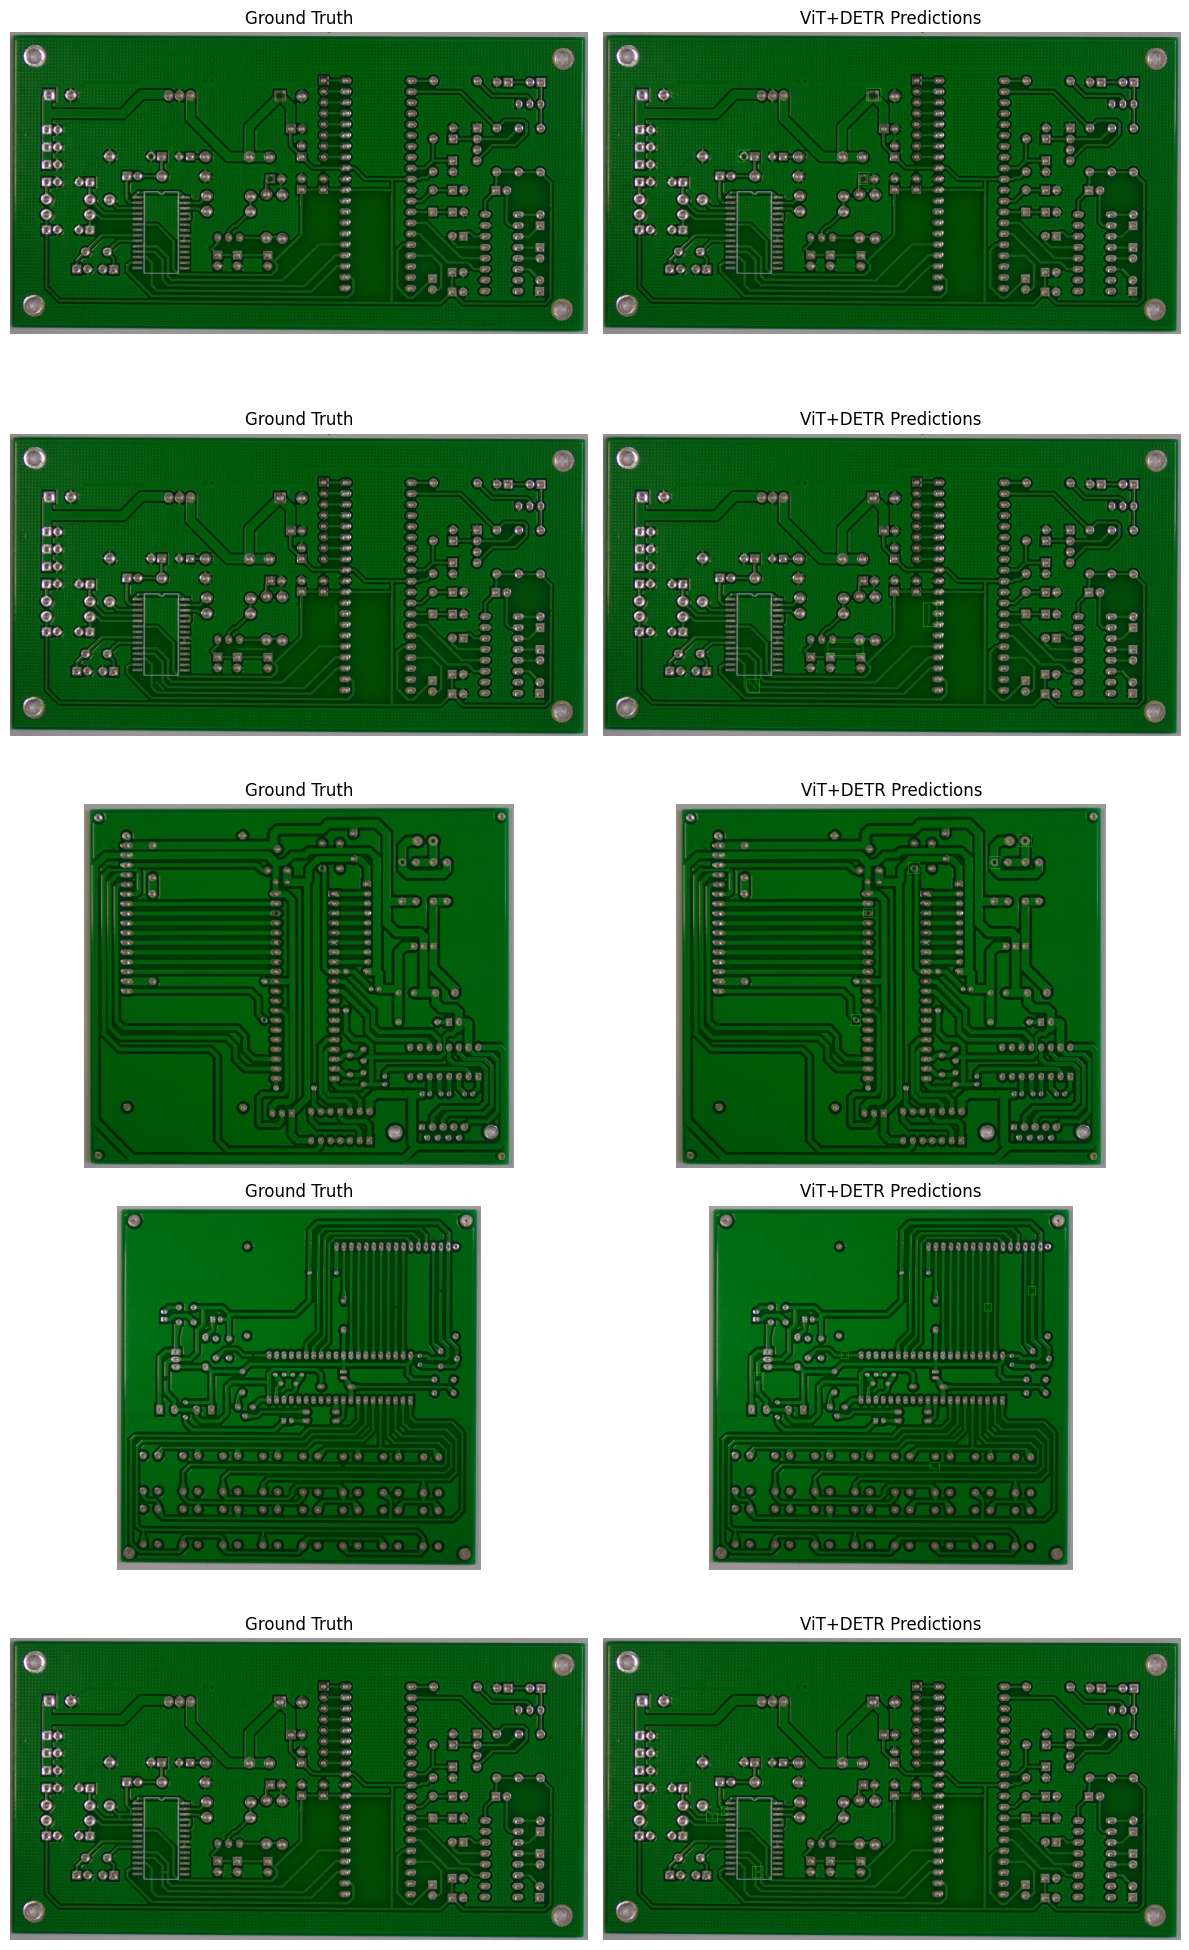

In [37]:
fig,axes = plt.subplots(5,2, figsize=(12,20))
for row in range(5):
    idx = random.randrange(len(val_ds))
    pil_img, tgt = val_ds[idx]
    axes[row,0].imshow(pil_img); axes[row,0].set_title("Ground Truth"); axes[row,0].axis("off")
    draw = ImageDraw.Draw(pil_img)
    w,h = pil_img.size
    # draw GT boxes (denormalize)
    for box in tgt["boxes"]:
        cx,cy,bw,bh = box.tolist()
        x0 = (cx - bw/2)*w; y0 = (cy - bh/2)*h
        x1 = x0 + bw*w;    y1 = y0 + bh*h
        draw.rectangle([x0,y0,x1,y1], outline="lime", width=2)

    # run DETR
    inputs = processor(images=pil_img, return_tensors="pt").to(DEVICE)
    outs = model(**inputs)
    dets = processor.post_process_object_detection(
        outs, target_sizes=[(h,w)], threshold=0.5
    )[0]
    axes[row,1].imshow(pil_img); axes[row,1].set_title("ViT+DETR Predictions"); axes[row,1].axis("off")
    draw2 = ImageDraw.Draw(pil_img)
    for box in dets["boxes"]:
        x0,y0,x1,y1 = box.tolist()
        draw2.rectangle([x0,y0,x1,y1], outline="red", width=2)

plt.tight_layout()

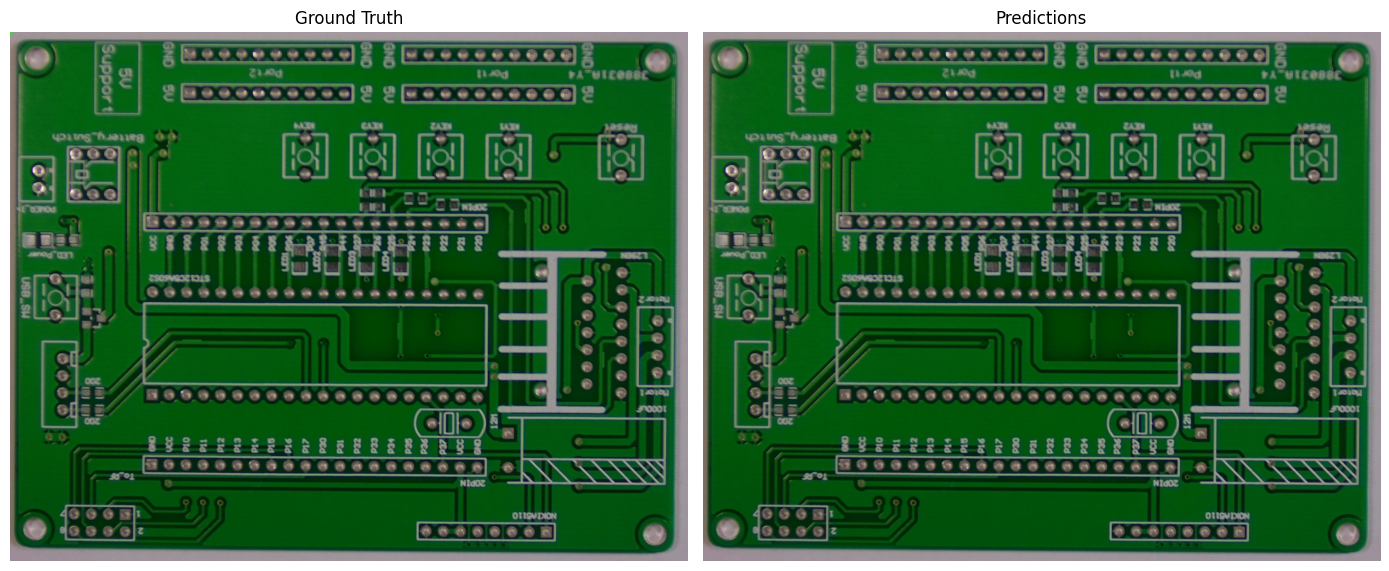

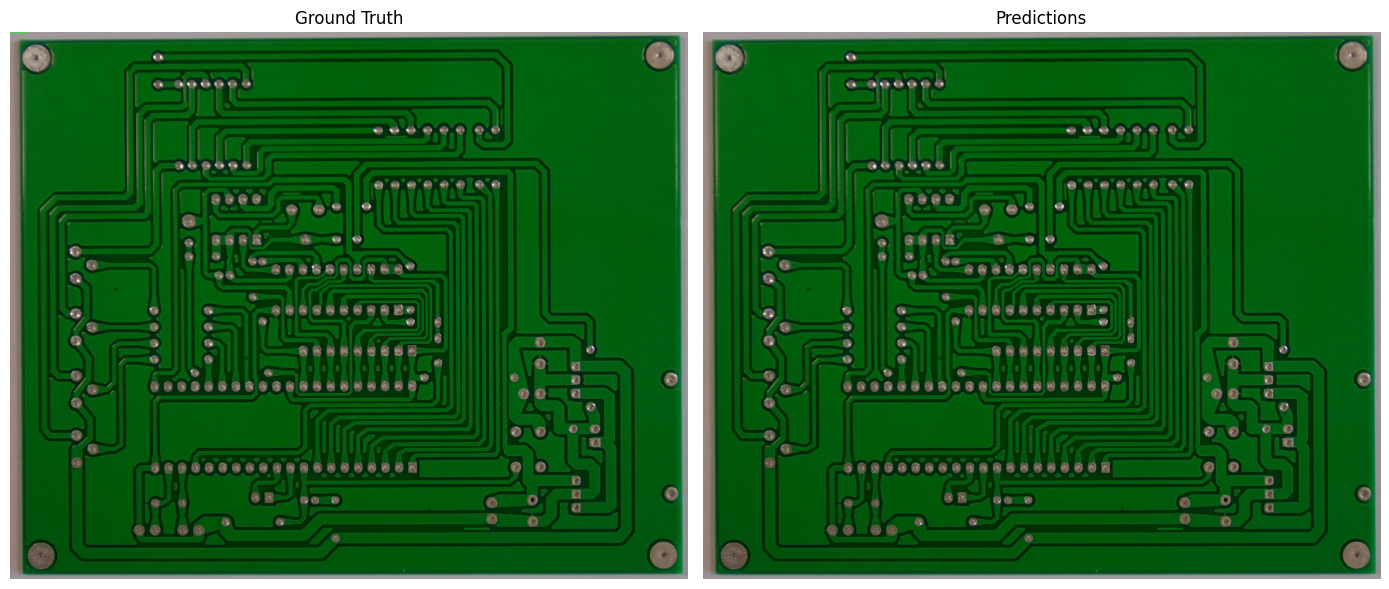

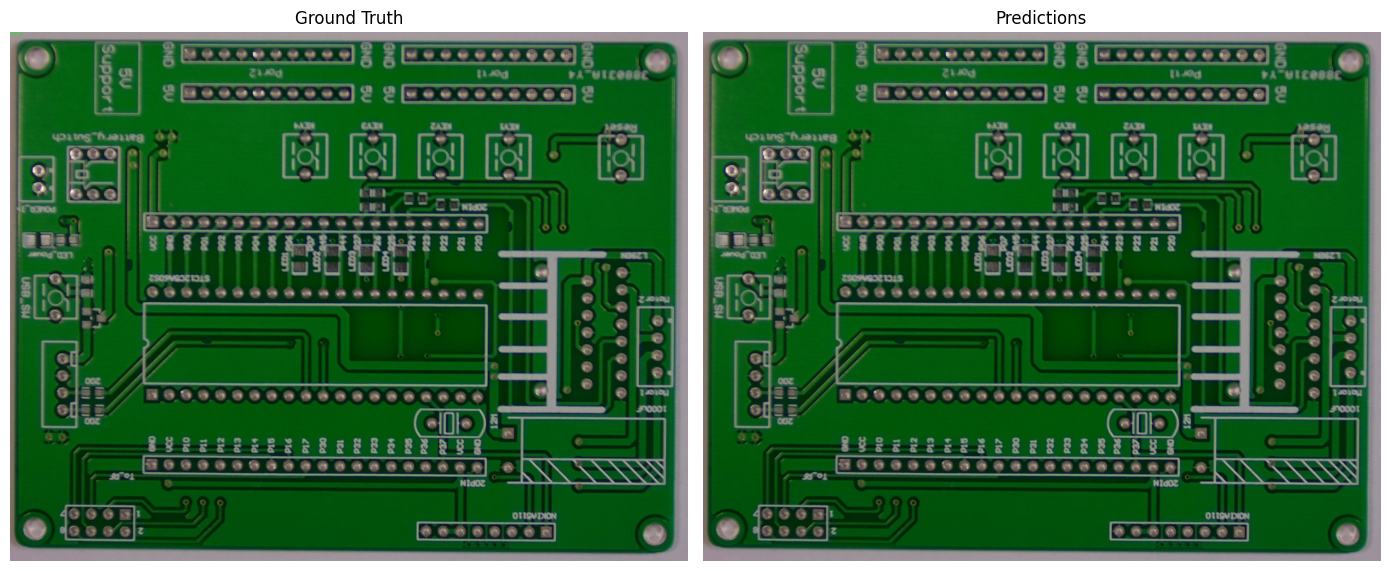

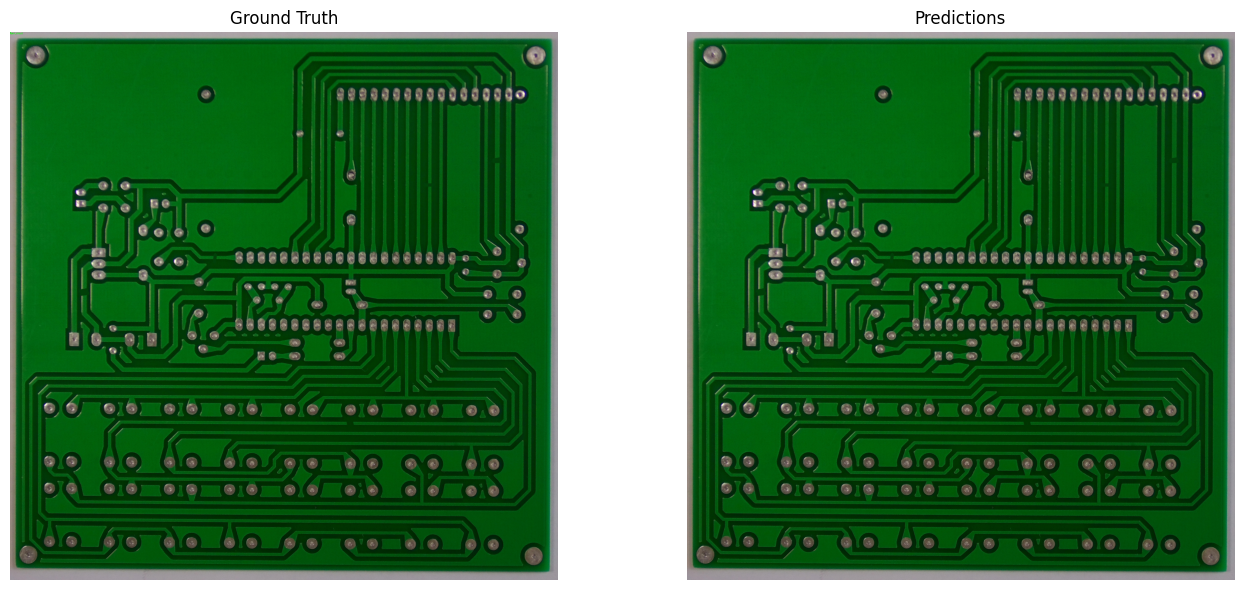

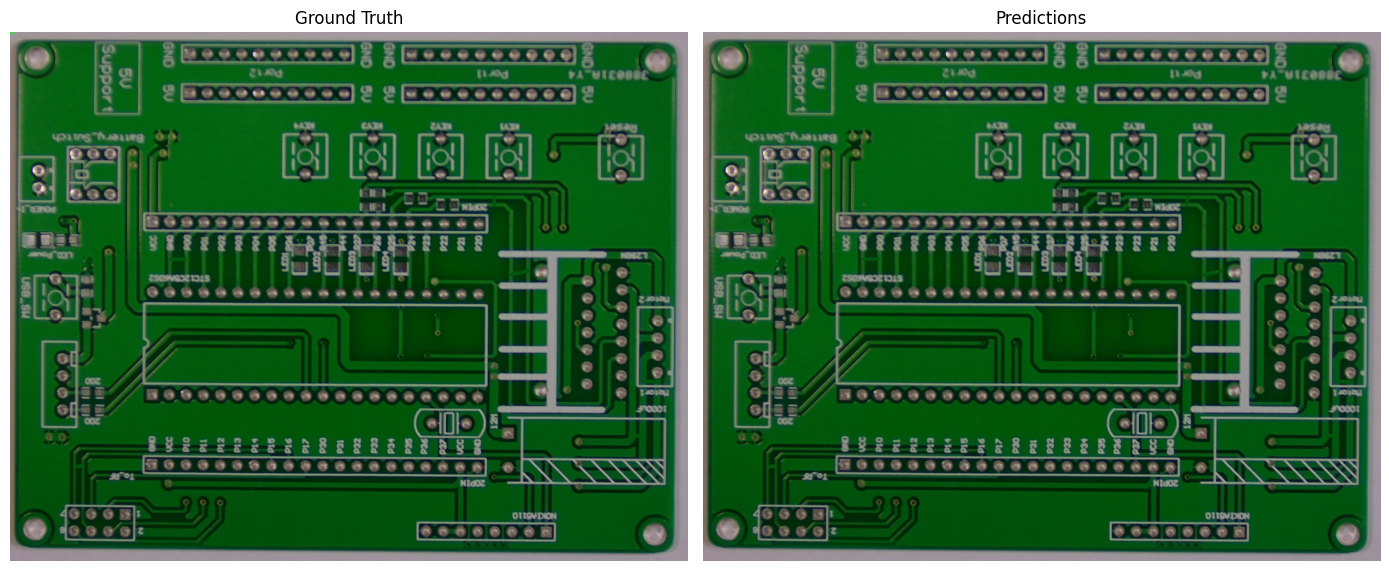

In [45]:
import random
import torch
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

# Make sure model is in eval mode and on the right device
model.eval()
model.to(DEVICE)

def show_detr_vs_gt(dataset, model, processor, class_names, device, score_thr=0.5, n=5):
    """
    For n random images from `dataset`, shows:
      • Left:  ground‑truth boxes (green)
      • Right: DETR predictions (red + scores)
    """
    # prepare a font for drawing scores
    try:
        font = ImageFont.truetype("arial.ttf", size=16)
    except IOError:
        font = ImageFont.load_default()

    for _ in range(n):
        # 1) pick a random sample
        img_obj, target = dataset[random.randrange(len(dataset))]
        # if your dataset returns a tensor, convert back to PIL
        pil = TF.to_pil_image(img_obj) if torch.is_tensor(img_obj) else img_obj

        # 2) draw GT
        img_gt = pil.copy()
        draw_gt = ImageDraw.Draw(img_gt)
        for box, lbl in zip(target["boxes"].tolist(), target["labels"].tolist()):
            x0, y0, x1, y1 = box  # absolute pixel coords
            # ensure correct ordering just in case
            xmin, xmax = sorted([x0, x1])
            ymin, ymax = sorted([y0, y1])
            draw_gt.rectangle([xmin, ymin, xmax, ymax], outline="lime", width=3)
            draw_gt.text((xmin, ymin), class_names[lbl], fill="lime", font=font)

        # 3) run DETR
        inputs = processor(images=[pil], return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        # post‑process into boxes, scores, labels
        det = processor.post_process_object_detection(
            outputs,
            target_sizes=[pil.size[::-1]],  # (height, width)
            threshold=score_thr
        )[0]

        # 4) draw predictions
        img_pred = pil.copy()
        draw_pred = ImageDraw.Draw(img_pred)
        for box, score, lbl in zip(det["boxes"], det["scores"], det["labels"]):
            x0, y0, x1, y1 = box.tolist()
            xmin, xmax = sorted([x0, x1])
            ymin, ymax = sorted([y0, y1])
            draw_pred.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
            txt = f"{class_names[lbl]} {score:.2f}"
            # offset label above the box if there's room
            draw_pred.text((xmin, max(ymin-15,0)), txt, fill="red", font=font)

        # 5) plot side by side
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))
        ax[0].imshow(img_gt)
        ax[0].set_title("Ground Truth")
        ax[0].axis("off")
        ax[1].imshow(img_pred)
        ax[1].set_title("Predictions")
        ax[1].axis("off")
        plt.tight_layout()
        plt.show()


# finally call it
show_detr_vs_gt(
    dataset=val_ds,
    model=model,
    processor=processor,
    class_names=CLASS_NAMES,
    device=DEVICE,
    score_thr=0.5,
    n=5
)

In [ ]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DetrImageProcessor,
    DetrForObjectDetection,
    Trainer,
    TrainingArguments
)
from sklearn.model_selection import train_test_split
import numpy as np
import albumentations as A # For data augmentation
from albumentations.pytorch import ToTensorV2
import evaluate # Hugging Face Evaluate library
import torchvision

# For mAP calculation
# !pip install torchmetrics -q # Uncomment if not already installed in Kaggle
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# --- Configuration ---
BASE_IMAGE_PATH = "/kaggle/input/pcb-dataset/PCB_Dataset/images"
BASE_ANNOTATION_PATH = "/kaggle/input/pcb-dataset/PCB_Dataset/Annotations"
CLASSES = ["Missing_hole", "Mouse_bite", "Open_circuit", "Short", "Spur", "Spurious_copper"]

# Create label mappings
label2id = {name: idx for idx, name in enumerate(CLASSES)}
id2label = {idx: name for idx, name in enumerate(CLASSES)}

# Model checkpoint
MODEL_CHECKPOINT = "facebook/detr-resnet-50"

# Training Hyperparameters (adjust as needed)
LEARNING_RATE = 1e-5
BATCH_SIZE = 4 # Adjust based on GPU memory (P4/T4 might need 2 or 4, P100 can handle more)
NUM_EPOCHS = 15 # Start with this, increase for better results if time permits
WEIGHT_DECAY = 1e-4
OUTPUT_DIR = "/kaggle/working/detr_pcb_defect_detector"
LOGGING_DIR = f"{OUTPUT_DIR}/logs"

# --- 1. Prepare Data Lists (Image paths and Annotation paths) ---
image_paths = []
annotation_paths = []

for class_name in CLASSES:
    class_image_dir = os.path.join(BASE_IMAGE_PATH, class_name)
    class_annot_dir = os.path.join(BASE_ANNOTATION_PATH, class_name)

    for fname in os.listdir(class_image_dir):
        if fname.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_image_dir, fname)
            # Assume annotation file has the same name but with .xml extension
            annot_fname = os.path.splitext(fname)[0] + ".xml"
            annot_path = os.path.join(class_annot_dir, annot_fname)

            if os.path.exists(annot_path):
                image_paths.append(img_path)
                annotation_paths.append(annot_path)
            else:
                print(f"Warning: Annotation not found for image {img_path}")

print(f"Found {len(image_paths)} images and {len(annotation_paths)} annotations.")

# Split data into training and validation sets
train_img_paths, val_img_paths, train_annot_paths, val_annot_paths = train_test_split(
    image_paths, annotation_paths, test_size=0.2, random_state=42
)
print(f"Training samples: {len(train_img_paths)}, Validation samples: {len(val_img_paths)}")


# --- 2. Define Data Augmentation (Optional but Recommended) ---
# Simple augmentations. For better results, explore more options.
# Note: Bounding boxes need to be transformed along with images.
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    # A.Resize(width=800, height=600), # DETR processor will handle resizing. If you resize here, ensure processor settings match
    # ToTensorV2 is not strictly needed here as DetrImageProcessor will convert to tensor
    # but if you do other pixel-level transforms, it's good.
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

transform_val = A.Compose([
    # A.Resize(width=800, height=600), # DETR processor will handle resizing
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


# --- 3. Create PyTorch Dataset ---
class PCBDefectDataset(Dataset):
    def __init__(self, image_paths, annotation_paths, image_processor, label2id, transforms=None, is_train=True):
        self.image_paths = image_paths
        self.annotation_paths = annotation_paths
        self.image_processor = image_processor # We'll use this in the collate_fn for batch processing
        self.label2id = label2id
        self.transforms = transforms
        self.is_train = is_train

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        annot_path = self.annotation_paths[idx]

        # Load image
        image = Image.open(img_path).convert("RGB")
        original_size = image.size # (width, height)

        # Parse XML
        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = []
        class_labels = [] # Numerical labels

        for obj_node in root.findall("object"):
            class_name = obj_node.find("name").text
            if class_name not in self.label2id:
                # print(f"Warning: Unknown class '{class_name}' in {annot_path}. Skipping.")
                continue

            bndbox_node = obj_node.find("bndbox")
            xmin = float(bndbox_node.find("xmin").text)
            ymin = float(bndbox_node.find("ymin").text)
            xmax = float(bndbox_node.find("xmax").text)
            ymax = float(bndbox_node.find("ymax").text)
            
            boxes.append([xmin, ymin, xmax, ymax])
            class_labels.append(self.label2id[class_name])

        # Apply augmentations if any
        if self.transforms:
            # Convert PIL image to numpy array for albumentations
            image_np = np.array(image)
            try:
                transformed = self.transforms(image=image_np, bboxes=boxes, class_labels=class_labels)
                image = Image.fromarray(transformed['image']) # Back to PIL for the processor
                boxes = transformed['bboxes']
                class_labels = transformed['class_labels']
            except ValueError as e:
                # print(f"Skipping augmentation for {img_path} due to error: {e}. Using original image.")
                # This can happen if all bounding boxes are removed by an augmentation like cropping.
                # Or if no bboxes were present to begin with.
                if not boxes: # If there were no boxes to begin with
                    image = Image.fromarray(image_np) # Original PIL image
                    boxes = []
                    class_labels = []


        # Prepare target in the format DetrImageProcessor expects for annotations
        # It wants a list of dictionaries, one per image
        target = {}

        annotations_coco = []
        for i, box in enumerate(boxes):
            xmin, ymin, xmax, ymax = box
            area = (xmax - xmin) * (ymax - ymin)
            annotations_coco.append({
                "image_id": torch.tensor(idx),
                "category_id": torch.tensor(class_labels[i]),
                "bbox": torch.tensor([xmin, ymin, xmax-xmin, ymax-ymin], dtype=torch.float32), # COCO: [xmin, ymin, width, height]
                "area": torch.tensor(area, dtype=torch.float32),
                "iscrowd": torch.tensor(0)
            })

        target = {"image_id": torch.tensor([idx]), "annotations": annotations_coco, "orig_size": torch.as_tensor([int(original_size[1]), int(original_size[0])])} # height, width

        return image, target # Return PIL image and target dict

# --- 4. Initialize Image Processor ---
image_processor = DetrImageProcessor.from_pretrained(MODEL_CHECKPOINT)

# --- 5. Create Datasets ---
train_dataset = PCBDefectDataset(train_img_paths, train_annot_paths, image_processor, label2id, transforms=transform_train, is_train=True)
val_dataset = PCBDefectDataset(val_img_paths, val_annot_paths, image_processor, label2id, transforms=transform_val, is_train=False)


# --- 6. Define Custom Data Collator ---
# This collator will use the image_processor to batch encode images and annotations
def collate_fn(batch):
    pixel_values = [item[0] for item in batch] # List of PIL images
    annotations = [item[1] for item in batch]  # List of target dicts

    # The image_processor needs images and annotations.
    # It will handle resizing, normalization, and formatting labels for the model.
    # For `annotations`, it can take COCO-style dicts.
    batch_encoding = image_processor(images=pixel_values, annotations=annotations, return_tensors="pt")
    
    # The 'labels' key from the processor contains the model-ready targets
    # Each element in batch_encoding['labels'] is a dict {'class_labels': tensor, 'boxes': tensor}
    return batch_encoding


# --- 7. Load Pre-trained Model ---
model = DetrForObjectDetection.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=len(CLASSES), # Your number of classes
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True # Allow head replacement
)

# --- 8. Training Arguments ---
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    fp16=torch.cuda.is_available(), # Use mixed precision if a GPU is available
    save_strategy="epoch",
    evaluation_strategy="epoch", # Evaluate after each epoch
    logging_dir=LOGGING_DIR,
    logging_strategy="steps",
    logging_steps=100, # Log every 100 steps
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    remove_unused_columns=False, # Important for custom collate_fn that might return extra keys
    load_best_model_at_end=True, # Load the best model based on a metric
    metric_for_best_model="map", # Use 'map' as the primary metric
    greater_is_better=True,
    report_to="tensorboard" # or "wandb" or "none"
)

# --- 9. Define Metrics Computation ---

def compute_metrics(eval_pred):
    metric = MeanAveragePrecision(box_format='xyxy') # pascal_voc uses xyxy
    logits, pred_boxes, inputs_labels = eval_pred.predictions, eval_pred.label_ids # Trainer might unpack labels differentl    
    gt_labels_for_metric = []

    
    all_preds_for_metric = []
    all_targets_for_metric = []

    # We need to iterate through the validation set to get `orig_size` for each sample.
    # This is complex within `compute_metrics`. A common way is to ensure `orig_size` is part of `inputs`
    # that Trainer passes to the model, and model returns it, or it's part of `label_ids`.


    target_sizes_list = [ann['orig_size'] for ann in annotations_from_eval_pred_label_ids] # This is where it gets tricky.

    # The output from the model:
    logits_batch = torch.from_numpy(eval_pred.predictions[0]) # batch_size, num_queries, num_classes + 1
    pred_boxes_batch = torch.from_numpy(eval_pred.predictions[1]) # batch_size, num_queries, 4 (center_x, center_y, width, height normalized)

    # The ground truth labels from the dataloader (passed to the model)
    # `eval_pred.label_ids` is a list of dicts: [{'class_labels': tensor, 'boxes': tensor (cxcywh normalized)}, ...]
    gt_labels_batch = eval_pred.label_ids

    preds_for_metric = []
    targets_for_metric = []

    for i in range(logits_batch.shape[0]): # Iterate over batch
        current_img_path = val_dataset.image_paths[i % len(val_dataset)] # Approx, if batch is sequential from val_dataset
        pil_img = Image.open(current_img_path)
        actual_target_size = torch.tensor([pil_img.height, pil_img.width]).unsqueeze(0).to(logits_batch.device)
        pil_img.close()

        # Post-process model outputs
        processed_outputs = image_processor.post_process_object_detection(
            outputs={'logits': logits_batch[i].unsqueeze(0), 'pred_boxes': pred_boxes_batch[i].unsqueeze(0)},
            threshold=0.1, # Confidence threshold
            target_sizes=actual_target_size
        )[0] # Get results for the first (and only) image in this micro-batch

        preds_for_metric.append({
            'boxes': processed_outputs['boxes'],
            'scores': processed_outputs['scores'],
            'labels': processed_outputs['labels'],
        })

        # Prepare ground truth for torchmetrics
        # `gt_labels_batch[i]` is `{'class_labels': tensor, 'boxes': tensor (normalized cxcywh)}`
        gt_dict = gt_labels_batch[i]
        gt_boxes_cxcywh_norm = gt_dict['boxes']
        gt_class_labels = gt_dict['class_labels']

        img_h, img_w = actual_target_size[0,0], actual_target_size[0,1]
        
        # Unnormalize boxes
        boxes_unnorm = torchvision.ops.box_convert(gt_boxes_cxcywh_norm, in_fmt='cxcywh', out_fmt='xyxy')
        boxes_unnorm[:, 0::2] *= img_w
        boxes_unnorm[:, 1::2] *= img_h
        
        targets_for_metric.append({
            'boxes': boxes_unnorm.cpu(),
            'labels': gt_class_labels.cpu(),
        })

    if not preds_for_metric or not targets_for_metric: # Handle empty batches or no detections
        return {"map": 0.0, "map_50": 0.0, "map_75": 0.0}

    try:
        metric.update(preds_for_metric, targets_for_metric)
        metric_results = metric.compute()
    except Exception as e:
        print(f"Error computing torchmetrics mAP: {e}")
        print(f"Preds: {preds_for_metric}")
        print(f"Targets: {targets_for_metric}")
        return {"map": 0.0, "map_50": 0.0, "map_75": 0.0} # Default on error

    return {k: v.item() if hasattr(v, 'item') else v for k, v in metric_results.items() if 'map' in k}


# --- 10. Initialize Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn, # Use our custom collate function
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor, # Effectively the processor
    compute_metrics=compute_metrics,
)

# --- 11. Start Training ---
print("Starting training...")
trainer.train()

# --- 12. Evaluate after training (optional, as it's done each epoch) ---
print("Evaluating final model...")
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# --- 13. Save the final model and processor ---
print("Saving model...")
trainer.save_model(os.path.join(OUTPUT_DIR, "final_model"))
image_processor.save_pretrained(os.path.join(OUTPUT_DIR, "final_model_processor"))

print(f"Training complete. Model saved to {os.path.join(OUTPUT_DIR, 'final_model')}")
print(f"To use the model later:\n"
      f"from transformers import DetrImageProcessor, DetrForObjectDetection\n"
      f"processor = DetrImageProcessor.from_pretrained('{os.path.join(OUTPUT_DIR, 'final_model_processor')}')\n"
      f"model = DetrForObjectDetection.from_pretrained('{os.path.join(OUTPUT_DIR, 'final_model')}')")